## Master's thesis : Evolution of sarcasm detection by using Machine Learning techniques

### Managing imports

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Reading datasets and formatting

#### Loading dataset 1

In [37]:


# Load the JSONL file (lines=True is key!)
df1 = pd.read_json('../Dataset/sarcasm_detection_shared_task_reddit_training.jsonl', lines=True)

# Map label: SARCASM -> 1, NOT_SARCASM -> 0
df1['label'] = df1['label'].replace({'SARCASM': 1, 'NOT_SARCASM': 0}).astype(int)

# Convert context list to string (join with ' ||| ')
df1['context'] = df1['context'].apply(lambda x: ' ||| '.join(x) if isinstance(x, list) else '')

# Save to CSV
df1.to_csv('../Dataset/sarcasm_detection_training_data.csv', index=False, columns=['label', 'response', 'context'])
df1


C:\Users\minht\AppData\Local\Temp\ipykernel_28460\1197742467.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['label'] = df1['label'].replace({'SARCASM': 1, 'NOT_SARCASM': 0}).astype(int)


,label,response,context
0,1,"Yeah I mean there's only one gender anyways, w...",LPT: If you're worried about hurting someone's...
1,1,"Sounds like you don't like science, you theist...",Promotional images for some guy's Facebook pag...
2,1,"Ofc play them in try mode, Blizzard were so ge...",My friends won't play Dota2; I won't play LoL;...
3,1,"I don't understand, Reddit told me that Hillar...",Poll: Convention boosts Clinton to 11-point le...
4,1,"yeh, they're the reigning triple premiers, why...",Wayne Ludbey: Jordan Lewis has the ultimate co...
...,...,...,...
4395,0,well you could've been adulting if you hadn't ...,8-9ft man found in ancient indian burial mound...
4396,0,Also they'll have to join the euro,Second Scottish independence referendum 'on th...
4397,0,plot: AI assists a cyborg in freelance investi...,Pinoy Cyborg by James Simmons ||| Mag-ingat sa...
4398,0,Some airlines proposed this but too much publi...,"The logic here is flawless! ||| No it isn't, f..."


#### Dataset 1 preparation


In [38]:
df1['input_text'] = df1['context'] + ' [SEP] ' + df1['response']

# Check the result
print(df1[['input_text', 'label']].head())

                                          input_text  label
0  LPT: If you're worried about hurting someone's...      1
1  Promotional images for some guy's Facebook pag...      1
2  My friends won't play Dota2; I won't play LoL;...      1
3  Poll: Convention boosts Clinton to 11-point le...      1
4  Wayne Ludbey: Jordan Lewis has the ultimate co...      1


#### Loading Dataset 2

In [39]:
# Only read the first 4400 rows and specific columns
cols_to_use = ['label', 'comment', 'parent_comment']

df2 = pd.read_csv('../Dataset/train-balanced-sarcasm.csv', usecols=cols_to_use, nrows=4400)

# Rename columns
df2 = df2.rename(columns={
    'comment': 'response',
    'parent_comment': 'context'
})

# Save to CSV
df2.to_csv('../Dataset/sarcasm_detection_single_context_training_data.csv', index=False)
df2

,label,response,context
0,1,That's exactly what a country who made up a ho...,China Tells Trump That Climate Change Is No Ho...
1,1,but it still snows,Facts for those who dispute man-made climate c...
2,0,"lol, you can't make this stuff up.","""Suppression of dissent is about as facist as ..."
3,0,He didn't drink the compliance,"The Worst ""Got Talent"" Judges Go on a Power Trip"
4,0,"In the Half Life series, the reason Gordon Fre...",What 'fan theories' have blown your mind with ...
...,...,...,...
4395,1,"Not to be sexist but uhhhh, stupid women have ...","""Not tryna be racist but uhhh"""
4396,0,He's opposed only when they don't pick him.,Wait wait. Please. Let me stop laughing at the...
4397,0,Round Aboot.,Canadian Solution to SimCity's Round-about Pro...
4398,0,That's some pretty impressive camouflage though.,As a hunter i find this super pathetic.


#### Dataset 2 preparation

In [40]:
df2['input_text'] = df2['context'] + ' [SEP] ' + df2['response']

# Check the result
print(df2[['input_text', 'label']].head())

                                          input_text  label
0  China Tells Trump That Climate Change Is No Ho...      1
1  Facts for those who dispute man-made climate c...      1
2  "Suppression of dissent is about as facist as ...      0
3  The Worst "Got Talent" Judges Go on a Power Tr...      0
4  What 'fan theories' have blown your mind with ...      0


#### Datasets value count

In [41]:
print("Dataset 1:")
print(df1['label'].value_counts())
print("\nDataset 2:")
print(df2['label'].value_counts())

Dataset 1:
label
1    2200
0    2200
Name: count, dtype: int64

Dataset 2:
label
0    2504
1    1896
Name: count, dtype: int64


In [42]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df1['input_text'], df1['label'],
    test_size=0.2, random_state=42, stratify=df1['label']
)

# Save train
train_df1 = pd.DataFrame({'input_text': X_train, 'label': y_train})
train_df1.to_csv("../Dataset/train_data.csv", index=False)

# Save test
test_df1 = pd.DataFrame({'input_text': X_test, 'label': y_test})
test_df1.to_csv("../Dataset/test_data.csv", index=False)

print("Train and test splits saved!")


Train and test splits saved!


In [44]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)

svm = SVC(class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_vec, y_train)

# Save the model and vectorizer for later use
joblib.dump(svm, "../Dataset/temp/svm_model.joblib")
joblib.dump(vectorizer, "../Dataset/temp/tfidf_vectorizer.joblib")

print("Training complete. Model and vectorizer saved.")

Training complete. Model and vectorizer saved.


Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       440
           1       0.59      0.58      0.59       440

    accuracy                           0.59       880
   macro avg       0.59      0.59      0.59       880
weighted avg       0.59      0.59      0.59       880



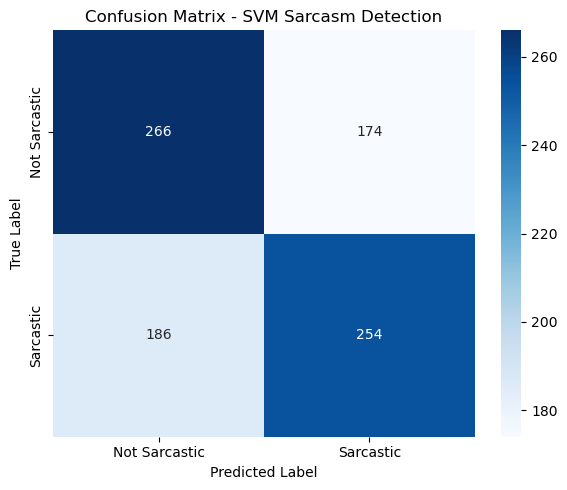

In [46]:
# Load test data, model, and vectorizer
test_df = pd.read_csv("../Dataset/test_data.csv")
X_test = test_df['input_text']
y_test = test_df['label']

vectorizer = joblib.load("../Dataset/temp/tfidf_vectorizer.joblib")
svm = joblib.load("../Dataset/temp/svm_model.joblib")

# Transform test data and predict
X_test_vec = vectorizer.transform(X_test)
y_pred = svm.predict(X_test_vec)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ['Not Sarcastic', 'Sarcastic']

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM Sarcasm Detection')
plt.tight_layout()
plt.show()